In [92]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
data = pd.read_csv('./hochgerner_2018.data.gz',sep='\t',index_col=0)
anno = pd.read_csv('./hochgerner_2018.anno',sep='\t',header=None)
anno = anno[1].values


In [93]:
anno

array(['nIPC', 'CA1-Sub', 'ImmAstro', ..., 'nIPC', 'nIPC', 'CA'],
      dtype=object)

In [94]:
#install seaborn for plotting if you don't have it installed
#!pip install seaborn

In [95]:
import seaborn

In [96]:
#We will first normalize each cell by total count per cell.
percell_sum = data.sum(axis=0)
pergene_sum = data.sum(axis=1)

preprocessed_data = data / percell_sum.values[None, :] * np.median(percell_sum)
preprocessed_data = preprocessed_data.values

#transform the preprocessed_data array by `x := log (1+x)`
preprocessed_data = np.log(1 + preprocessed_data)

#standard scaling
preprocessed_data_mean = preprocessed_data.mean(axis=1)
preprocessed_data_std = preprocessed_data.std(axis=1)
preprocessed_data = (preprocessed_data - preprocessed_data_mean[:, None]) / \
                     preprocessed_data_std[:, None]



In [97]:
#preprocess by PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
pca.fit(preprocessed_data.T)
pca_data = pca.transform(preprocessed_data.T)

Text(0, 0.5, 'PC2')

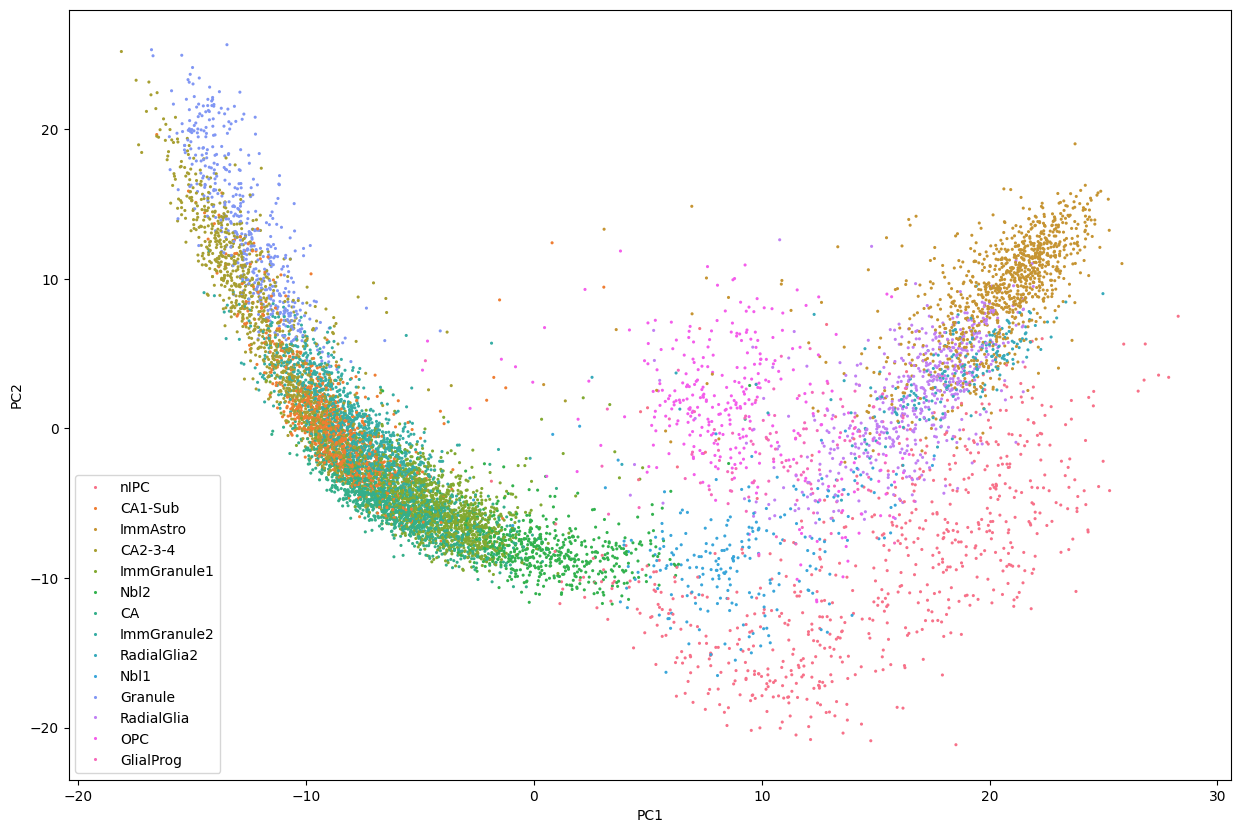

In [98]:
#visualize PCA result
plt.figure(figsize=(15,10))
seaborn.scatterplot(x=pca_data[:,0], y=pca_data[:,1], linewidth = 0, s=5, hue=anno)
plt.xlabel('PC1')
plt.ylabel('PC2')

##  GraphDR: nonlinear dimensionality reduction that preserves linear interpretability

GraphDR is a nonlinear dimensionality reduction method that preserves the linear interpretability while improving on cell type representation quality. GraphDR combines the advantages of linear methods such as PCA and nonlinear methods such as t-SNE. Unlike t-SNE, GraphDR is also suitable for comparison across datasets.

In [123]:
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from scipy.sparse import eye
from numpy.linalg import inv

def GraphDR(X, n_neighbors=10, n_components=20, l=10, no_rotation=True):
    """
    Compute the GraphDR of a dataset.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        The input data.

    n_neighbors : int, optional
        Number of neighbors to use when constructing the graph.

    n_components : int, optional
        Number of components to keep.

    l : float, optional
        The regularization parameter.

    no_rotation : bool, optional
        If True, skip computing W and set W = I.

    Returns
    -------
    Z : array-like, shape (n_samples, n_components)
        The GraphDR of the dataset.
    """
    # Step 1: Construct the adjacency matrix
    A = kneighbors_graph(X, n_neighbors=n_neighbors, mode="connectivity", include_self=True, n_jobs=-1).toarray()
    
    # Step 2: Ensure the adjacency matrix is symmetric
    A = 0.5 * (A + A.T)
    
    # Step 3: Compute the degree matrix
    D = np.diag(np.sum(A, axis=1))
    
    # Step 4: Compute the graph Laplacian
    L = D - A
    
    # Step 5: Compute the matrix K
    I = eye(len(L)).toarray()  # Identity matrix
    K = inv(I + l * L)
    
    # Step 6: Compute Z
    if no_rotation:
        # Skip computing W and set W = I
        Z = K @ X
    else:
        # Compute W and then Z
        # Compute the top d eigenvectors of (X^T(I + λL)^(-1)X)
        X_tilde = X.T @ K
        eigvals, eigvecs = np.linalg.eigh(X_tilde @ X)
        W = eigvecs[:, -n_components:]  # Select top d eigenvectors
        Z = K @ X @ W
    
    # Slice Z to keep the desired number of components
    Z = Z[:, :n_components]

    return Z

# Example usage with your data
# Assuming pca_data is already defined
graphdr_data = GraphDR(pca_data)


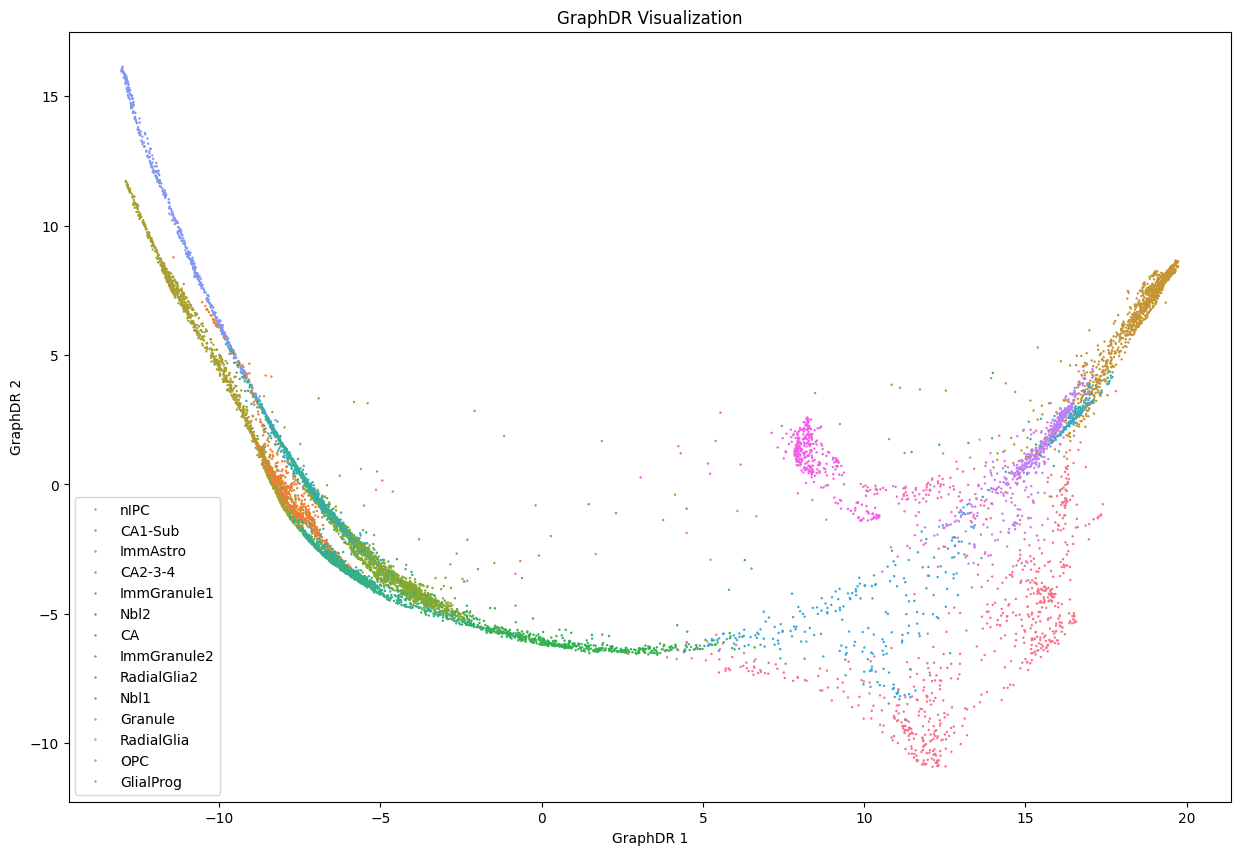

In [100]:
#compare your graphdr output with this one, it should look similar (remember to adjust lambda_ and see its effect)

plt.figure(figsize=(15,10))
seaborn.scatterplot(x=graphdr_data[:,0], y=graphdr_data[:,1], linewidth = 0, s=3, hue=anno)
plt.xlabel('GraphDR 1')
plt.ylabel('GraphDR 2')
plt.title('GraphDR Visualization')
plt.show()

Text(0, 0.5, 'GraphDR 2')

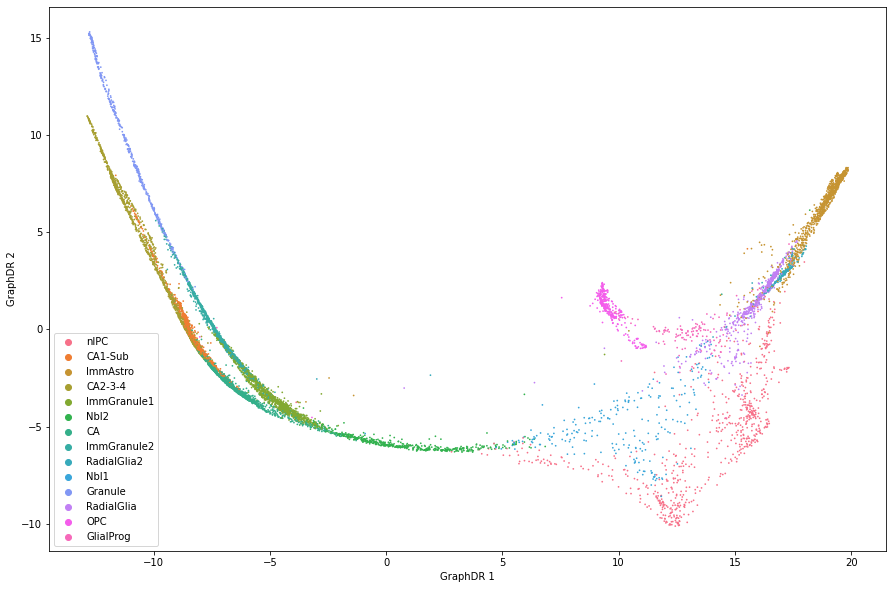

In [10]:
#compare your graphdr output with this one, it should look similar (remember to adjust lambda_ and see its effect)

plt.figure(figsize=(15,10))
seaborn.scatterplot(x=graphdr_data[:,0], y=graphdr_data[:,1], linewidth = 0, s=3, hue=anno)
plt.xlabel('GraphDR 1')
plt.ylabel('GraphDR 2')

In [31]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [83]:
anno.values

array([['nIPC'],
       ['CA1-Sub'],
       ['ImmAstro'],
       ...,
       ['nIPC'],
       ['nIPC'],
       ['CA']], dtype=object)

In [105]:
graphdr_data[:, 1]

array([-4.23415723,  1.34753933, -0.80632163, ..., -6.94792208,
       -5.45721558, -4.9167113 ])

In [131]:
def create_plotly_3d(data, anno):
    fig_pca = px.scatter_3d(
        x=pca_data[:, 0], y=pca_data[:, 1], z=pca_data[:, 2],
        color=anno, title="PCA 3D Visualization",
        labels={'x': 'PC1', 'y': 'PC2', 'z': 'PC3'}
    )
    
    return fig_pca

In [132]:
import plotly.express as px
create_plotly_3d_pca(pca_data, anno)

In [134]:
create_plotly_3d(data, anno)

In [137]:
import plotly.graph_objs as go
import plotly.express as px

unique_anno = np.unique(anno)
traces = []

for ct in unique_anno:
    mask = (anno == ct)
    traces.append(go.Scatter3d(
        x=pca_data[mask, 0],
        y=pca_data[mask, 1],
        z=pca_data[mask, 2],
        mode='markers',
        marker=dict(size=2, opacity=0.8),
        name=ct
    ))

layout = go.Layout(
    title='PCA 3D Visualization',
    scene=dict(
        xaxis_title='PCA 1',
        yaxis_title='PCA 2',
        zaxis_title='PCA 3'
    )
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

In [136]:
import plotly.graph_objs as go
import plotly.express as px

unique_anno = np.unique(anno)
traces = []

for ct in unique_anno:
    mask = (anno == ct)
    traces.append(go.Scatter3d(
        x=graphdr_data[mask, 0],
        y=graphdr_data[mask, 1],
        z=graphdr_data[mask, 2],
        mode='markers',
        marker=dict(size=2, opacity=0.8),
        name=ct
    ))

layout = go.Layout(
    title='GraphDR 3D Visualization',
    scene=dict(
        xaxis_title='GraphDR 1',
        yaxis_title='GraphDR 2',
        zaxis_title='GraphDR 3'
    )
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

With GraphDR reprsentation, the cell types are now much better separated than PCA, while the overal interpretation of the space is preserved.
In this case there are a small number of cells floating in between branches. This is because nearest neigbor graph can contain spurious edges connecting cells that belong to different cell types. This usually only happens for a small fraction of cells, but we can fix this by performing the optional extra steps of automatically prune spurious graph edges, as shown below: